In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

import scipy.stats as stats

random_state = 42

In [2]:
df = acquire.zillow_data()

Reading from local CSV...


In [3]:
df = prepare.prep_zillow(df)
train, validate, test = prepare.train_validate_test_split(df)
target = 'logerror'
outlier_columns = [col for col in df.columns if ((df[col].dtype != 'object') & (col not in [target, 'latitude', 'longitude']))]
train, validate, test = prepare.remove_outliers(train, validate, test, 3, outlier_columns)
train, validate, test = prepare.scale_zillow(train, test, validate, target)
train, validate, test = prepare.encode_zillow(train, test, validate, target)

train	 n = 29001
test	 n = 10358
validate n = 12429
train	 n = 15874
test	 n = 5731
validate n = 6750


**Questions:**
1) are there clusters based on combination of bedroomcnt and bathroomcnt that are drivers of logerror?

2) are there clusters based on combination of bedroomcnt, bathroomcnt, and sqft that are drivers of logerror?

3) are there clusters based on combination of latitude/longitude that are drivers of logerror?

4) are there clusters based on combination of tax value per sqft, bedroomcnt, and bathroomcnt that are drivers of logerror?

5) which features are most highly correlated with the target?

#### 1) are there clusters based on combination of bedroomcnt and bathroomcnt that are drivers of logerror?

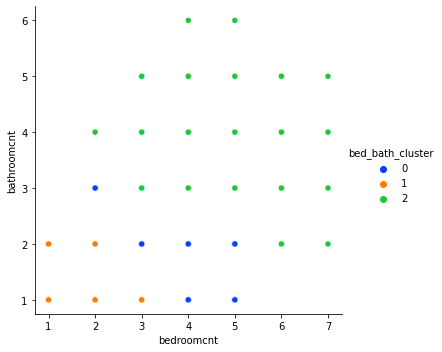

In [4]:
# creating clusters with KMeans
x = train[['scaled_bedroomcnt', 'scaled_bathroomcnt']]
kmeans = KMeans(n_clusters = 3, random_state=random_state)
kmeans.fit(x)
train['bed_bath_cluster'] = kmeans.predict(x)

# visualize the clusters
sns.relplot(data=train, x='bedroomcnt', y='bathroomcnt', hue='bed_bath_cluster', palette='bright')
plt.show()

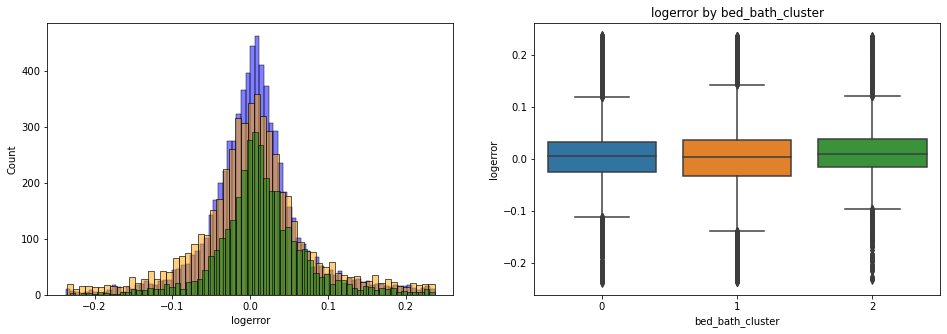

In [5]:
# visualize logerrror by bed_bath_cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plt.title('logerror by bed_bath_cluster')
sns.histplot(train[train.bed_bath_cluster == 0].logerror, color='blue', alpha = .5, ax=ax1)
sns.histplot(train[train.bed_bath_cluster == 1].logerror, color='orange', alpha = .5, ax=ax1)
sns.histplot(train[train.bed_bath_cluster == 2].logerror, color='green', alpha = .5, ax=ax1)
sns.boxplot(data=train, x='bed_bath_cluster', y='logerror', ax=ax2)
plt.show()

In [6]:
# testing whether there is a significant difference in logerror among the clusters
cluster_0 = train[train.bed_bath_cluster == 0]
cluster_1 = train[train.bed_bath_cluster == 1]
cluster_2 = train[train.bed_bath_cluster == 2]
alpha = .05
stat, p = stats.f_oneway(cluster_0.logerror, cluster_1.logerror, cluster_2.logerror)
print('stat = ', stat)
print('p = ', p)
if p < alpha:
    print('reject H0')
else: print('fail to reject H0')

stat =  25.339809268693223
p =  1.029423199371789e-11
reject H0


#### 2) are there clusters based on combination of bedroomcnt, bathroomcnt, and sqft that are drivers of logerror?


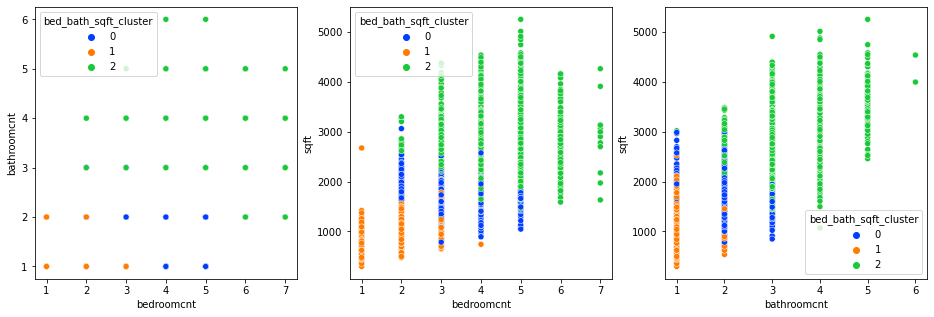

In [7]:
# creating clusters with KMeans
x = train[['scaled_bedroomcnt', 'scaled_bathroomcnt', 'scaled_sqft']]
kmeans = KMeans(n_clusters = 3, random_state=random_state)
kmeans.fit(x)
train['bed_bath_sqft_cluster'] = kmeans.predict(x)

# visualize the clusters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.scatterplot(data=train, x='bedroomcnt', y='bathroomcnt', hue='bed_bath_sqft_cluster', palette='bright', ax=ax1)
sns.scatterplot(data=train, x='bedroomcnt', y='sqft', hue='bed_bath_sqft_cluster', palette='bright', ax=ax2)
sns.scatterplot(data=train, x='bathroomcnt', y='sqft', hue='bed_bath_sqft_cluster', palette='bright', ax=ax3)
plt.show()

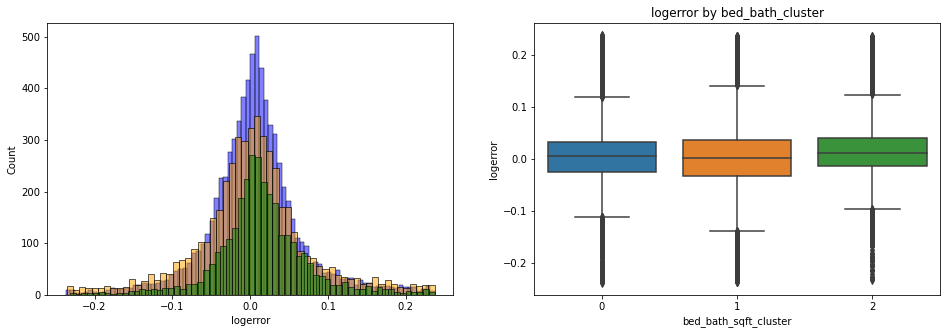

In [8]:
# visualize logerror by bed_bath_sqft cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plt.title('logerror by bed_bath_cluster')
sns.histplot(train[train.bed_bath_sqft_cluster == 0].logerror, color='blue', alpha = .5, ax=ax1)
sns.histplot(train[train.bed_bath_sqft_cluster == 1].logerror, color='orange', alpha = .5, ax=ax1)
sns.histplot(train[train.bed_bath_sqft_cluster == 2].logerror, color='green', alpha = .5, ax=ax1)
sns.boxplot(data=train, x='bed_bath_sqft_cluster', y='logerror', ax=ax2)
plt.show()

In [9]:
# testing whether there is a significant difference in logerror among the clusters
cluster_0 = train[train.bed_bath_sqft_cluster == 0]
cluster_1 = train[train.bed_bath_sqft_cluster == 1]
cluster_2 = train[train.bed_bath_sqft_cluster == 2]
alpha = .05
stat, p = stats.f_oneway(cluster_0.logerror, cluster_1.logerror, cluster_2.logerror)
print('stat = ', stat)
print('p = ', p)
if p < alpha:
    print('reject H0')
else: print('fail to reject H0')

stat =  28.96448373796259
p =  2.778341627048375e-13
reject H0


#### 3) are there clusters based on combination of latitude/longitude that are drivers of logerror?

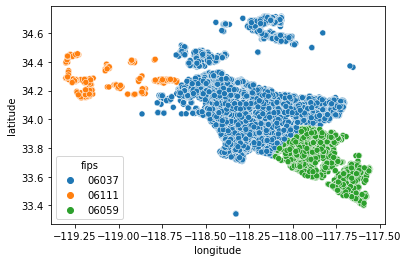

In [10]:
sns.scatterplot(x='longitude', y = 'latitude', data=train, hue='fips')
plt.show()

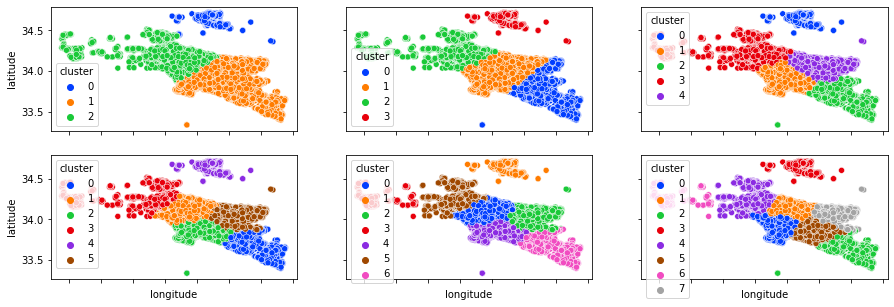

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True, sharex=True)

for i, k in enumerate(range(3,9)):
    
    # creating clusters with KMeans
    x = train[['scaled_latitude', 'scaled_longitude']]
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(x)
    train['cluster'] = kmeans.predict(x)

    # visualize the clusters
    y = int(i / 3)
    x = i % 3
    ax = sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster',
                         palette='bright', ax=axes[y,x])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

n_clusters=4 and n_clusters=5 are the most visually intuitive divisions. We will run ANOVA tests on logerror for each of those cluster groups:

In [12]:
for k in range(3, 9):

    # creating clusters with KMeans
    x = train[['scaled_latitude', 'scaled_longitude']]
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(x)
    train['cluster'] = kmeans.predict(x)

    # testing whether there is a significant difference in logerror among the clusters
    alpha = .05
    args = []
    for x in range(k):
        args.append(train[train.cluster == x].logerror)
    stat, p = stats.f_oneway(*args)
    
    print('-' * 50)
    print('n_clusters = ', k)
    print('stat = ', stat)
    print('p = ', p)
    if p < alpha:
        print('reject H0')
    else: print('fail to reject H0')

--------------------------------------------------
n_clusters =  3
stat =  3.6776728549747952
p =  0.025303288347823184
reject H0
--------------------------------------------------
n_clusters =  4
stat =  25.959645460084747
p =  9.599367109817317e-17
reject H0
--------------------------------------------------
n_clusters =  5
stat =  16.118403334866006
p =  3.531896934121518e-13
reject H0
--------------------------------------------------
n_clusters =  6
stat =  25.04686811127582
p =  3.0846426205868345e-25
reject H0
--------------------------------------------------
n_clusters =  7
stat =  18.698837370723293
p =  8.505235560807114e-22
reject H0
--------------------------------------------------
n_clusters =  8
stat =  19.799517721597116
p =  1.3230041931807232e-26
reject H0


Since the test statistic is highest for n_clusters=4 we will assume that this group of clusters is most impactful on logerror (recognizing that this may not be a strictly correct interpretation of the test statistic's meaning). This also is the most visually intuitive geographic division, since it identifies the clearly separated northern cluster, and then divides the remaining segment into central, east, and west. 

In [13]:
# creating clusters with KMeans
x = train[['scaled_latitude', 'scaled_longitude']]
kmeans = KMeans(n_clusters=4, random_state=random_state)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

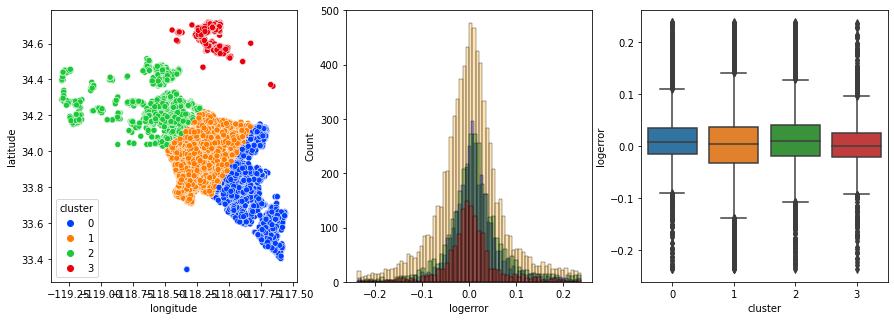

In [14]:
# visualizing lat/long clusters n_clusters = 4

# creating clusters with KMeans
x = train[['scaled_latitude', 'scaled_longitude']]
kmeans = KMeans(n_clusters=4, random_state=random_state)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

# creating visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
alpha = .3 #transparency for histplot
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster', palette='bright', ax=axes[0])
sns.histplot(train[train.cluster == 1].logerror, color='orange', alpha=alpha, ax=axes[1])
sns.histplot(train[train.cluster == 0].logerror, color='blue', alpha=alpha, ax=axes[1])
sns.histplot(train[train.cluster == 2].logerror, color='green', alpha=alpha, ax=axes[1])
sns.histplot(train[train.cluster == 3].logerror, color='red', alpha=alpha, ax=axes[1])
sns.boxplot(data=train, x='cluster', y='logerror', ax=axes[2])
plt.show()

#### 4) are there clusters based on combination of tax value per sqft, bedroomcnt, and bathroomcnt that are drivers of logerror?


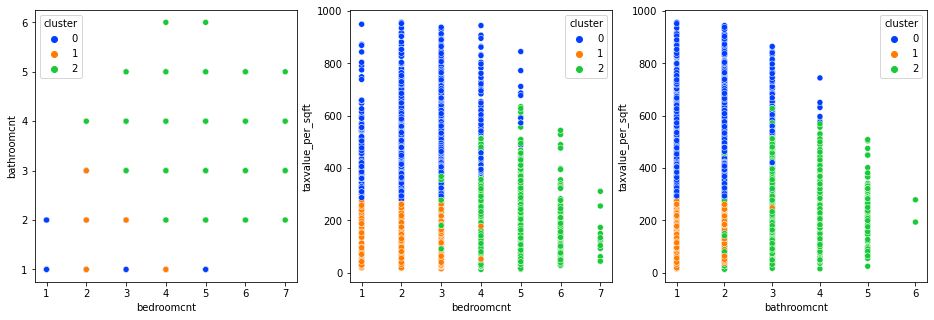

In [15]:
# creating clusters with KMeans
x = train[['scaled_bedroomcnt', 'scaled_bathroomcnt', 'scaled_taxvalue_per_sqft']]
kmeans = KMeans(n_clusters=3, random_state=random_state)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)

# visualize the clusters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
sns.scatterplot(data=train, x='bedroomcnt', y='bathroomcnt', hue='cluster', palette='bright', ax=ax1)
sns.scatterplot(data=train, x='bedroomcnt', y='taxvalue_per_sqft', hue='cluster', palette='bright', ax=ax2)
sns.scatterplot(data=train, x='bathroomcnt', y='taxvalue_per_sqft', hue='cluster', palette='bright', ax=ax3)
plt.show()

In [16]:
# testing whether there is a significant difference in logerror among the clusters
alpha = .05
stat, p = stats.f_oneway(train[train.cluster == 0].logerror,
                         train[train.cluster == 1].logerror, 
                         train[train.cluster == 2].logerror)
print('stat = ', stat)
print('p = ', p)
if p < alpha:
    print('reject H0')
else: print('fail to reject H0')

stat =  34.07793676095531
p =  1.7054045908566085e-15
reject H0


If we assume that the test statistic resulting from the ANOVA tests performed above is a valid representation of how much impact each cluster has on logerror, then these clusters (based on number of bedrooms, number of bathrooms, and tavalue per sqft), have the most significant impact on logerror. This is line with a traditional understanding in real estate that these three factors tend to have a large impact on home value. We will be sure to use these clusters moving forward in our regression modeling. 

In the future, we should explore different values for n_clusters to see if a different number of clusters may have more impact. 

In [17]:
# removing cluster columns from train df since these were intended to be temporary during exploration
for col in [col for col in train.columns if 'cluster' in col]:
    train = train.drop(columns=col)

#### 5) Which features are most highly correlated with the target?



In [18]:
def value_correlations(train, target):
    '''
    This function takes in the zillow train sample and uses pandas and seaborn to create a
    ordered list and heatmap of the correlations between the various quantitative feeatures and the target. 
    '''
    # create a dataframe of correlation values, sorted in descending order
    corr = pd.DataFrame(train.corr().abs()[target]).sort_values(by=target, ascending=False)
    # rename the correlation column
    corr.columns = ['correlation (abs)']
    # establish figure size
    plt.figure(figsize=(10,8))
    # creat the heatmap using the correlation dataframe created above
    sns.heatmap(corr, annot=True)
    # establish a plot title
    plt.title('Features\' Correlation with Value')
    # display the plot
    plt.show()

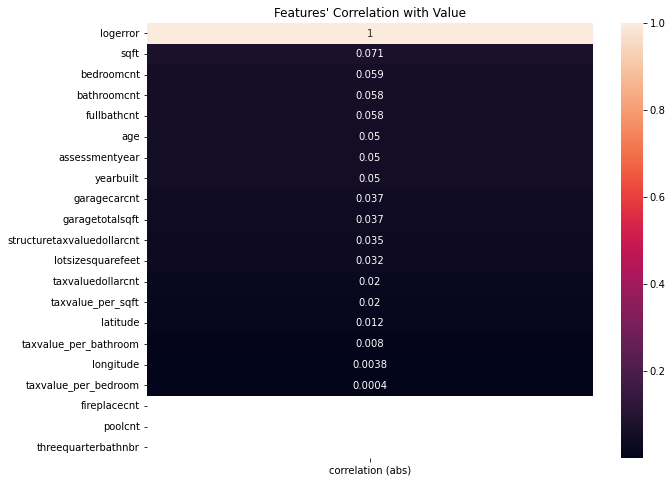

In [19]:
quant_cols = [col for col in train.columns if (train[col].dtype != 'object')
                                            & ('enc_' not in col)
                                            & ('scaled_' not in col)
                                            & ('bool_' not in col)
                                            & (col != 'abs_logerror')]
value_correlations(train[quant_cols], target)

From this we can see that no one feature by itself has a very strong correlation with logerror. 

However, we will use this to guide which features will go into our initial model, by taking all features whose correlation value is .05 or higher...
- sqft
- bedroomcnt
- bathroomcnt
- fullbathcnt
- age
- assessmentyear
- yearbuilt
- garagecarcnt
- garagetotalsqft
    
...then adding our cluster features to see if they have an impact on the model performance.